In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import os
import tarfile
import scipy.io as sio
import numpy as np
import random
import cv2

In [ ]:
#look at this
#https://www.kaggle.com/jutrera/training-a-densenet-for-the-stanford-car-dataset
#https://www.kaggle.com/mrudhuhas/classifying-cars-cnn
#https://mlbhanuyerra.github.io/2019-10-31-ClassifyingCarImagesByVehileType/


In [ ]:
def save_train_data(fnames, labels, bboxes):
    src_folder ='/tmp/car_ims'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in range(num_samples):
        fname = fnames[i][8:]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)

        src_image = cv2.imread(src_path)
        height, width = src_image.shape[:2]

        # margins of 16 pixels (Crop image according to a given bounding box)
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        if i in train_indexes:
            dst_folder = '/tmp/car_ims/train/'
        else:
            dst_folder = '/tmp/car_ims/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        dst_image = src_image[y1:y2, x1:x2]
        cv2.imwrite(dst_path, dst_image)

### Download and Separate Data

We first need to download the data from a remote server and seperate the data into training and testing sets. Note that you only need to download the data once, if you have downloaded the data before do not run the code in this section.

In [ ]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/car_ims.tgz \
  -O /tmp/car_ims.tgz

--2020-08-14 14:12:18--  http://imagenet.stanford.edu/internal/car196/car_ims.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘/tmp/car_ims.tgz’

/tmp/car_ims.tgz    100%[===================>]   1.82G  5.03MB/s    in 2m 34s  

2020-08-14 14:14:52 (12.1 MB/s) - ‘/tmp/car_ims.tgz’ saved [1956628579/1956628579]



In [ ]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/cars_annos.mat \
  -O /tmp/cars_annos.mat

--2020-08-14 14:14:53--  http://imagenet.stanford.edu/internal/car196/cars_annos.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘/tmp/cars_annos.mat’

/tmp/cars_annos.mat 100%[===================>] 385.23K   220KB/s    in 1.8s    

2020-08-14 14:14:56 (220 KB/s) - ‘/tmp/cars_annos.mat’ saved [394471/394471]



In [ ]:
!wget --no-check-certificate \
  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat \
  -O /tmp/cars_test_annos.mat

--2020-08-14 14:14:57--  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘/tmp/cars_test_annos.mat’

/tmp/cars_test_anno 100%[===================>] 181.40K   168KB/s    in 1.1s    

2020-08-14 14:14:58 (168 KB/s) - ‘/tmp/cars_test_annos.mat’ saved [185758/185758]



In [ ]:
!rm -rf /tmp/car_ims/train/
!rm -rf /tmp/car_ims/test/
!rm -rf /tmp/car_ims/valid/

Unzip the compressed data. (You do not need to understand how this works)

In [ ]:
local_tar = '/tmp/car_ims.tgz'
my_tar = tarfile.open(local_tar)
my_tar.extractall('/tmp')
my_tar.close()

In [ ]:
car_annotation= sio.loadmat('/tmp/cars_annos.mat')

annotations = car_annotation['annotations']
annotations = np.transpose(annotations)

fnames = []
class_ids = []
labels = []
bboxes  = []
for annotation in annotations:
  bbox_x1 = annotation[0][1][0][0]
  bbox_y1 = annotation[0][2][0][0]
  bbox_x2 = annotation[0][3][0][0]
  bbox_y2 = annotation[0][4][0][0]

  class_id = annotation[0][5][0][0]
  bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
  labels.append(f'{class_id:06}')

  file_name = annotation[0][0][0]
  class_ids.append(class_id)
  fnames.append(file_name)

labels_count = np.unique(class_ids).shape[0]
print(np.unique(class_ids))
print('The number of different cars is %d' % labels_count)

save_train_data(fnames, labels, bboxes)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196


In [ ]:
annotations

array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8))],
       [(array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8))],
       [(array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8))],
       ...,
       [(array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8))],
       [(array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), arra

### Create a data generator

In [ ]:
datagen = ImageDataGenerator()
train_iter = datagen.flow_from_directory('/tmp/car_ims/train/', target_size=(224, 224), class_mode='categorical', batch_size=32)
test_iter = datagen.flow_from_directory('/tmp/car_ims/valid/', target_size=(224, 224), class_mode='categorical', batch_size=32)

Found 12948 images belonging to 196 classes.
Found 3237 images belonging to 196 classes.


In [ ]:
print(train_iter[0][0].shape)

(32, 224, 224, 3)


### Build Model

In [ ]:
# TODO
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import datasets, models
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Model

In [ ]:
#resnet?
resnet = ResNet50V2(weights="imagenet", include_top=False, input_shape = (224, 224, 3))
x = (resnet.output)
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
predictions = Dense(196, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)

for layer in model.layers[:30]:
    layer.trainable=False
for layer in model.layers[30:]:
    layer.trainable=True

optimizer = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', factor = 0.1, patience = 1)


94674944/94668760 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/tmp/car_ims/train/', target_size=(224, 224), class_mode='categorical', batch_size=32)
test_generator = test_datagen.flow_from_directory('/tmp/car_ims/valid/', target_size=(224, 224), class_mode='categorical', batch_size=32)

Found 12948 images belonging to 196 classes.
Found 3237 images belonging to 196 classes.


In [ ]:
with tf.device("GPU:0"):
  history = model.fit(train_generator, epochs=40, steps_per_epoch= 100, validation_data=test_generator, callbacks=[reduce_lr])

Epoch 1/40
100/100 [==============================] - 97s 965ms/step - loss: 6.5316 - accuracy: 0.0100 - val_loss: 5.0673 - val_accuracy: 0.0297
Epoch 2/40
100/100 [==============================] - 93s 926ms/step - loss: 5.5345 - accuracy: 0.0422 - val_loss: 4.5882 - val_accuracy: 0.0754
Epoch 3/40
100/100 [==============================] - 94s 936ms/step - loss: 4.7509 - accuracy: 0.0897 - val_loss: 4.0019 - val_accuracy: 0.1470
Epoch 4/40
100/100 [==============================] - 93s 933ms/step - loss: 4.1560 - accuracy: 0.1434 - val_loss: 3.4800 - val_accuracy: 0.2122
Epoch 5/40
100/100 [==============================] - 92s 918ms/step - loss: 3.6232 - accuracy: 0.1997 - val_loss: 2.9192 - val_accuracy: 0.3077
Epoch 6/40
100/100 [==============================] - 93s 928ms/step - loss: 3.2061 - accuracy: 0.2531 - val_loss: 2.6158 - val_accuracy: 0.3621
Epoch 7/40
100/100 [==============================] - 92s 923ms/step - loss: 2.8582 - accuracy: 0.3222 - val_loss: 2.3061 - val_ac

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
evaluation = model.evaluate(test_generator)
print('accuracy:', evaluation[1])
print('loss:', evaluation[0])

102/102 [==============================] - 24s 233ms/step - loss: 0.8149 - accuracy: 0.7726
accuracy: 0.7726289629936218
loss: 0.8148780465126038


In [ ]:
evaluation = model.evaluate(train_generator)
print('accuracy:', evaluation[1])
print('loss:', evaluation[0])

405/405 [==============================] - 220s 542ms/step - loss: 0.4756 - accuracy: 0.8804
accuracy: 0.880367636680603
loss: 0.47559264302253723


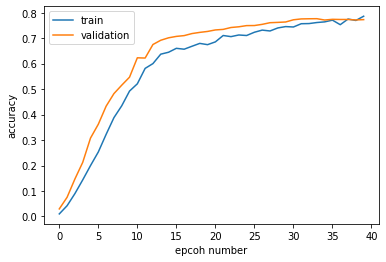

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epoch number")
plt.ylabel("accuracy")
plt.legend(['train','validation'])

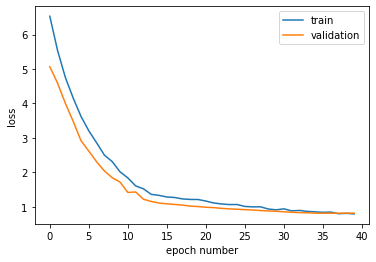

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epoch number")
plt.ylabel("loss")
plt.legend(['train','validation'])

In [ ]:
print(test_generator)

In [ ]:
test_generator2 = test_datagen.flow_from_directory('/tmp/car_ims/valid/', target_size=(224, 224), class_mode='categorical', batch_size=3237)
X, y = next(test_generator2)

Found 3237 images belonging to 196 classes.


In [ ]:
yhat = model.predict(X)
max_yhat = np.argmax(yhat, axis = -1)

In [ ]:
y_true = np.argmax(y, axis = -1)

In [ ]:
print(max_yhat[:20])
print(y_true[:20])

[147 129 107  77 100  60  34 190  92 157 180  47 121  62 195 179  76  94
 180  71]
[147 129 107  77 100  60  25 190  92 157 114  47 121  62 195 179  76  94
 183  71]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, max_yhat)


In [ ]:
cm

array([[15,  0,  0, ...,  0,  0,  0],
       [ 0,  4,  1, ...,  0,  0,  0],
       [ 0,  1, 11, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 21,  0,  0],
       [ 0,  0,  0, ...,  0, 14,  0],
       [ 0,  0,  0, ...,  0,  0, 14]])

In [ ]:
full_sum

3237

In [ ]:
column_sums = np.sum(cm, axis=1)
row_sums = np.sum(cm, axis=0)
full_sum = np.sum(cm)

for i in range(196):
  correct = cm[i][i]
  total = column_sums[i]
  accuracy = correct/total
  print('class',i,':',accuracy)

class 0 : 1.0
class 1 : 0.5714285714285714
class 2 : 0.8461538461538461
class 3 : 0.7857142857142857
class 4 : 0.5217391304347826
class 5 : 0.75
class 6 : 0.9375
class 7 : 0.5263157894736842
class 8 : 0.2962962962962963
class 9 : 0.7
class 10 : 0.8
class 11 : 0.8421052631578947
class 12 : 0.46153846153846156
class 13 : 0.3181818181818182
class 14 : 0.8181818181818182
class 15 : 0.7
class 16 : 0.5789473684210527
class 17 : 0.6190476190476191
class 18 : 0.7142857142857143
class 19 : 0.7407407407407407
class 20 : 0.72
class 21 : 0.8
class 22 : 0.2857142857142857
class 23 : 0.8333333333333334
class 24 : 0.625
class 25 : 0.8
class 26 : 0.8666666666666667
class 27 : 0.5
class 28 : 0.75
class 29 : 0.7142857142857143
class 30 : 0.46153846153846156
class 31 : 0.8125
class 32 : 0.7857142857142857
class 33 : 0.6875
class 34 : 0.5
class 35 : 0.5789473684210527
class 36 : 0.9285714285714286
class 37 : 0.6666666666666666
class 38 : 0.6666666666666666
class 39 : 0.9090909090909091
class 40 : 0.8125
c